# Google Drive Interface Setup

In [ ]:
from google.colab import drive, auth
import sys

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Pull down github repo, store in colab runtime memory
!git clone https://github.com/andrew-loeber/proj_utils_207.git

Cloning into 'proj_utils_207'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 34 (delta 10), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (34/34), 8.72 KiB | 557.00 KiB/s, done.
Resolving deltas: 100% (10/10), done.


In [ ]:
# Tell Python to also look in this repo when running an import
sys.path.insert(1, "/content/proj_utils_207")

In [ ]:
# Authenticate google account and give back the session access token
auth.authenticate_user()
gcloud_token = !gcloud auth print-access-token
gcloud_token

['ya29.a0AfB_byCPt-7nsbZmlxSzLyVF3N8fY6m1e5U-_00NkE_jPlwua3x-TUQ-LsthEKizzDiIuVyl82sBnl5UoZzXc57XQttY8AyAdmo_F2lRHws4CCFejZ6ZkGDpd5GKCfnGUZqYRxeKzsxdGKEIR20ZcyyVTHlKaCgYKAcgSARMSFQHsvYlsXK5594jIA8R719nx3ao_gw0163']

In [ ]:
from gdriveinterface import GDriveInterface
import proj_ref

In [ ]:
# Show email address, username, and the path of the shared project folder on
# your Google Drive instance
gdi = GDriveInterface(gcloud_token)
shared_folder_path = gdi.shared_folder_path
gdi.__dict__

{'email': 'aloeber@berkeley.edu',
 'account': 'aloeber',
 'shared_folder_path': '/content/drive/MyDrive/207-Project'}

In [ ]:
# Show name keys and paths for tracked files
proj_ref.files

{'taxonomy': 'BirdCLEF/eBird_Taxonomy_v2021.csv',
 'orig_metadata': 'BirdCLEF/train_metadata_with_duration.csv',
 'sample_metadata': 'data/sample_metadata.csv',
 'species_metadata': 'data/species_metadata.csv',
 'train_metadata': 'data/train_metadata.csv',
 'test_metadata': 'data/test_metadata.csv'}

In [ ]:
# Show name keys and paths for tracked directories
proj_ref.dirs

{'orig_audio': {'path': 'BirdCLEF/train_audio'},
 'train_audio': {'path': 'data/train/audio_files'},
 'test_audio': {'path': 'data/test/audio_files'},
 'train_npy_full': {'path': 'data/train/librosa_loaded'},
 'test_npy_full': {'path': 'data/test/librosa_loaded'},
 'train_npy_loud5s': {'path': 'data/train/librosa_loaded_loudest_5sec'},
 'test_npy_loud5s': {'path': 'data/test/librosa_loaded_loudest_5sec'}}

### **Usage examples**

##### Query specific file based on named key
```
command: gdi.get_file_path('taxonomy')
returns: '/content/drive/MyDrive/207-Project/BirdCLEF/eBird_Taxonomy_v2021.csv'
```

##### Query specific directory based on named key
```
command: gdi.get_dir_path('orig_audio')
returns: '/content/drive/MyDrive/207-Project/BirdCLEF/train_audio'
```

##### Query specific sample record based on named keys for directory and file
```
command: gdi.get_sample_path('train_audio', 'barswa/XC132406.ogg')
returns: '/content/drive/MyDrive/207-Project/data/train/audio_files/barswa/XC132406.ogg'
```

##### Provide full path given a custom partial path
```
command: gdi.join_to_shared('images/sandpiper.jpeg')
returns: '/content/drive/MyDrive/207-Project/images/sandpiper.jpeg'
```


# Imports & Setup

In [ ]:
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Load Test DataFrame & Encode Features

In [ ]:
test_df = pd.read_csv(gdi.join_to_shared('Inference/test.csv'))

test_df.head()

,primary_label,filename,duration_secs,type,filename_npy,rating,country,continent
0,eaywag1,eaywag1/XC131436.ogg,14.027755,call,eaywag1/XC131436.npy,good,FR,EUROPE
1,eaywag1,eaywag1/XC132637.ogg,40.359229,call,eaywag1/XC132637.npy,good,PL,EUROPE
2,eaywag1,eaywag1/XC133615.ogg,13.505351,call,eaywag1/XC133615.npy,poor,RU,EUROPE
3,eaywag1,eaywag1/XC138886.ogg,54.987755,song,eaywag1/XC138886.npy,poor,RU,EUROPE
4,eaywag1,eaywag1/XC145084.ogg,10.605760,call,eaywag1/XC145084.npy,good,KZ,ASIA


In [ ]:
sum(test_df['duration_secs'] < 8)

0

In [ ]:
col_to_le = 'primary_label'

In [ ]:
le = LabelEncoder()
le.fit(test_df[col_to_le])

LabelEncoder()

In [ ]:
test_df[col_to_le + '_enc'] = le.transform(test_df[col_to_le])
test_df

,primary_label,filename,duration_secs,type,filename_npy,rating,country,continent,primary_label_enc
0,eaywag1,eaywag1/XC131436.ogg,14.027755,call,eaywag1/XC131436.npy,good,FR,EUROPE,2
1,eaywag1,eaywag1/XC132637.ogg,40.359229,call,eaywag1/XC132637.npy,good,PL,EUROPE,2
2,eaywag1,eaywag1/XC133615.ogg,13.505351,call,eaywag1/XC133615.npy,poor,RU,EUROPE,2
3,eaywag1,eaywag1/XC138886.ogg,54.987755,song,eaywag1/XC138886.npy,poor,RU,EUROPE,2
4,eaywag1,eaywag1/XC145084.ogg,10.605760,call,eaywag1/XC145084.npy,good,KZ,ASIA,2
...,...,...,...,...,...,...,...,...,...
376,barswa,barswa/XC746902.ogg,13.139002,blank,barswa/XC746902.npy,good,ES,EUROPE,0
377,barswa,barswa/XC747068.ogg,10.135011,blank,barswa/XC747068.npy,good,DK,EUROPE,0
378,barswa,barswa/XC747069.ogg,10.109025,blank,barswa/XC747069.npy,good,DK,EUROPE,0
379,barswa,barswa/XC756634.ogg,66.072018,blank,barswa/XC756634.npy,good,LK,ASIA,0


In [ ]:
test_df = test_df[[
  'primary_label'
  , 'primary_label_enc'
  , 'filename_npy'
  , 'duration_secs'
]]

test_df

,primary_label,primary_label_enc,filename_npy,duration_secs
0,eaywag1,2,eaywag1/XC131436.npy,14.027755
1,eaywag1,2,eaywag1/XC132637.npy,40.359229
2,eaywag1,2,eaywag1/XC133615.npy,13.505351
3,eaywag1,2,eaywag1/XC138886.npy,54.987755
4,eaywag1,2,eaywag1/XC145084.npy,10.605760
...,...,...,...,...
376,barswa,0,barswa/XC746902.npy,13.139002
377,barswa,0,barswa/XC747068.npy,10.135011
378,barswa,0,barswa/XC747069.npy,10.109025
379,barswa,0,barswa/XC756634.npy,66.072018


# Load & frame audio

In [ ]:
def load_audio_frames(
    df
    , print_iters=20
    , dir_key='test_npy_full'
    , frame_length_s=8.0
    , hop_length_s=4.0
    , sr=16000
    ):

  recs = len(df)
  frame_length = int(frame_length_s * sr)
  hop_length = int(hop_length_s * sr)

  print(f'{recs} files')
  print(f'{frame_length_s}s frames with {hop_length_s}s overlap')
  print()

  array_sizes = []
  all_frames = []
  frames_info = []

  for i in range(recs):
    if (i+1) % print_iters == 0:
      print(f'{i+1} of {recs}')
    row = dict(df.iloc[i])
    path = gdi.get_sample_path(dir_key=dir_key, file_key=row['filename_npy'])
    audio_full = np.load(path)
    array_sizes.append(len(audio_full))
    audio_frames = np.array(
        tf.signal.frame(audio_full, frame_length, hop_length, pad_end=False)
    )
    all_frames.extend(audio_frames)
    num_frames = len(audio_frames)
    frame_num = 1
    for frame in audio_frames:
      frame_dict = row.copy()
      frame_dict.update(
          {
              'frame_length_s':   frame_length_s
              , 'hop_length_s':   hop_length_s
              , 'total_frames':   num_frames
              , 'frame_id':       frame_num
          }
      )
      frames_info.append(frame_dict)
      frame_num += 1

  print(f'{recs} of {recs}...DONE')
  print()
  print(f'{len(all_frames)} total frames created')

  return array_sizes, np.array(all_frames), pd.DataFrame(frames_info)


In [ ]:
test_sizes, test_frames, test_frames_df = load_audio_frames(test_df)

381 files
8.0s frames with 4.0s overlap

20 of 381
40 of 381
60 of 381
80 of 381
100 of 381
120 of 381
140 of 381
160 of 381
180 of 381
200 of 381
220 of 381
240 of 381
260 of 381
280 of 381
300 of 381
320 of 381
340 of 381
360 of 381
380 of 381
381 of 381...DONE

3405 total frames created


In [ ]:
test_labels = np.array(test_frames_df['primary_label_enc'])
test_labels.shape

(3405,)

In [ ]:
test_labels[:10]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
test_sizes[0:10]

[224444,
 645747,
 216085,
 879804,
 169692,
 204382,
 576784,
 1115533,
 374016,
 680448]

In [ ]:
test_frames.shape

(3405, 128000)

In [ ]:
test_frames_df

,primary_label,primary_label_enc,filename_npy,duration_secs,frame_length_s,hop_length_s,total_frames,frame_id
0,eaywag1,2,eaywag1/XC131436.npy,14.027755,8.0,4.0,2,1
1,eaywag1,2,eaywag1/XC131436.npy,14.027755,8.0,4.0,2,2
2,eaywag1,2,eaywag1/XC132637.npy,40.359229,8.0,4.0,9,1
3,eaywag1,2,eaywag1/XC132637.npy,40.359229,8.0,4.0,9,2
4,eaywag1,2,eaywag1/XC132637.npy,40.359229,8.0,4.0,9,3
...,...,...,...,...,...,...,...,...
3400,barswa,0,barswa/XC756634.npy,66.072018,8.0,4.0,15,14
3401,barswa,0,barswa/XC756634.npy,66.072018,8.0,4.0,15,15
3402,barswa,0,barswa/XC83449.npy,18.546032,8.0,4.0,3,1
3403,barswa,0,barswa/XC83449.npy,18.546032,8.0,4.0,3,2


In [ ]:
test_df['file_duration_samples'] = test_sizes
test_df

<ipython-input-32-88173f6a0633>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['file_duration_samples'] = test_sizes


,primary_label,primary_label_enc,filename_npy,duration_secs,file_duration_samples
0,eaywag1,2,eaywag1/XC131436.npy,14.027755,224444
1,eaywag1,2,eaywag1/XC132637.npy,40.359229,645747
2,eaywag1,2,eaywag1/XC133615.npy,13.505351,216085
3,eaywag1,2,eaywag1/XC138886.npy,54.987755,879804
4,eaywag1,2,eaywag1/XC145084.npy,10.605760,169692
...,...,...,...,...,...
376,barswa,0,barswa/XC746902.npy,13.139002,210224
377,barswa,0,barswa/XC747068.npy,10.135011,162160
378,barswa,0,barswa/XC747069.npy,10.109025,161744
379,barswa,0,barswa/XC756634.npy,66.072018,1057152


# Define helper functions

In [ ]:
def audio_to_db_stft(
    audio
    , n_fft=64
    , hop_length=64):

  S = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
  S = np.abs(S)
  S = librosa.amplitude_to_db(S, ref=np.max)
  S -= np.mean(S)
  S /= np.std(S)
  return S

In [ ]:
def transform_frames(frames, transform, transform_args):
  return np.array([transform(frame.copy(), **transform_args) for frame in frames])

def transform_frame(frame, transform, transform_args):
  return transform(frame.copy(), **transform_args)

# Transform test frames into normalized db-scaled STFT matrices

In [ ]:
transform = audio_to_db_stft
transform_args = {'n_fft': 64, 'hop_length': 64}

In [ ]:
test_features = transform_frames(test_frames, transform, transform_args)
test_features.shape

(3405, 33, 2001)

In [ ]:
test_features[0].shape

(33, 2001)

In [ ]:
sample_audio_num = 36
test_frames_df.iloc[sample_audio_num]

primary_label                     eaywag1
primary_label_enc                       2
filename_npy         eaywag1/XC145148.npy
duration_secs                   69.720816
frame_length_s                        8.0
hop_length_s                          4.0
total_frames                           16
frame_id                                1
Name: 36, dtype: object

In [ ]:
sample_audio = test_frames[sample_audio_num]
sample_audio

array([-7.6349088e-06, -7.7533359e-06,  5.2524338e-06, ...,
        6.9169793e-04, -6.9093369e-03,  3.8361277e-03], dtype=float32)

In [ ]:
Audio(sample_audio, rate=16000, autoplay=True)

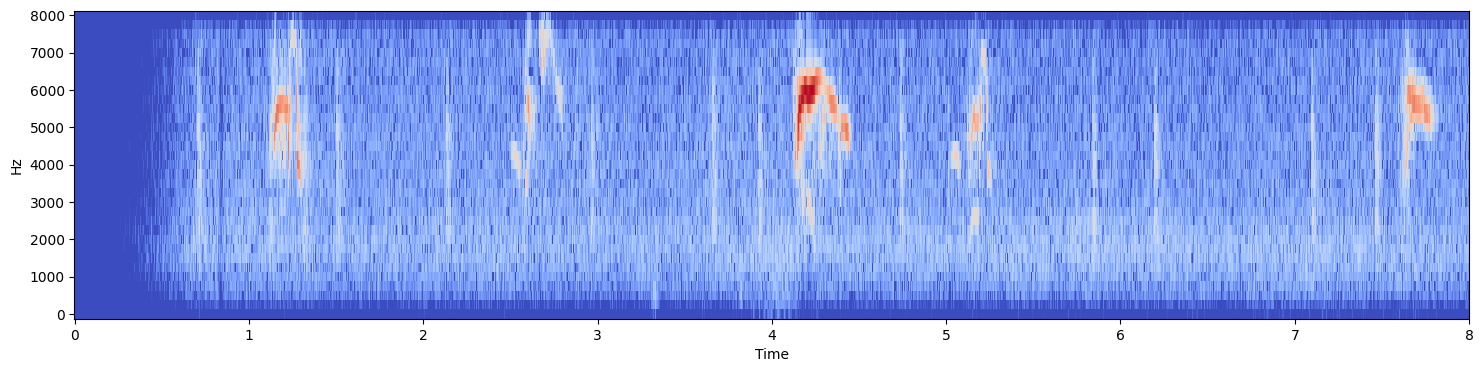

In [ ]:
sample_spec = transform_frame(sample_audio, transform, transform_args)
plt.figure(figsize=(18,4))
librosa.display.specshow(
    sample_spec
    , x_axis='time'
    , y_axis='linear'
    , sr=16000
    , hop_length=64
)

# Define custom keras layers

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        cls_randroll = np.random.randn(projection_dim) / 10
        self.cls_token = tf.Variable(
            initial_value=cls_randroll.reshape((1, 1, -1))
            , trainable=True
            , dtype=tf.float32
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        batch_len = tf.shape(patch)[0]
        cls_token_rpt = tf.repeat(self.cls_token, batch_len, axis=0)
        return tf.concat([cls_token_rpt, encoded], axis=-2)

In [ ]:
class FFN(layers.Layer):
    def __init__(self, dim, middle_dim, dropout_rate):
        super().__init__()
        self.dim = dim
        self.middle_dim = middle_dim
        self.dropout_rate = dropout_rate
        self.expand = layers.Dense(middle_dim, activation=tf.nn.gelu)
        self.compress = layers.Dense(dim, activation=tf.nn.gelu)
        self.dropout = layers.Dropout(dropout_rate)

    def call(self, patch):
        x = self.expand(patch)
        x = self.dropout(x)
        x = self.compress(x)
        x = self.dropout(x)
        return x

# Load STFT ViT model

In [ ]:
model = tf.keras.models.load_model(gdi.join_to_shared('Inference/ViT_8s_stft.keras')
  , custom_objects={"PatchEncoder": PatchEncoder, "FFN": FFN}
)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 33, 2001)]   0           []                               
                                                                                                  
 gaussian_dropout (GaussianDrop  (None, 33, 2001)    0           ['input_1[0][0]']                
 out)                                                                                             
                                                                                                  
 permute (Permute)              (None, 2001, 33)     0           ['gaussian_dropout[0][0]']       
                                                                                                  
 reshape (Reshape)              (None, 2001, 33, 1)  0           ['permute[0][0]']          

In [ ]:
model.evaluate(
    x=test_features
    , y=test_labels
    , batch_size=128
)

27/27 [==============================] - 59s 2s/step - loss: 0.1875 - acc: 0.9424


[0.18748560547828674, 0.9424375891685486]

In [ ]:
test_yhat = model.predict(
    x=test_features
)
test_yhat[:10]

107/107 [==============================] - 56s 518ms/step


array([[-1.234053  , -3.3991117 ,  4.039551  ],
       [-0.84235674, -3.023918  ,  2.9958384 ],
       [-1.7006508 , -2.6987789 ,  4.0030475 ],
       [-1.6266403 , -3.0328188 ,  4.188442  ],
       [-0.985274  , -3.3207297 ,  4.3990307 ],
       [-1.3454481 , -3.0584633 ,  4.186172  ],
       [-1.4167902 , -2.718497  ,  3.643932  ],
       [ 1.8665205 , -2.6728654 ,  0.39108604],
       [-0.52941066, -2.9489512 ,  2.9337204 ],
       [-1.1559672 , -2.7408195 ,  3.4549668 ]], dtype=float32)

In [ ]:
test_yhat_result = np.argmax(test_yhat, axis=-1)

In [ ]:
le.classes_

array(['barswa', 'comsan', 'eaywag1'], dtype=object)

In [ ]:
# show the classification report
print('\nTest Classification Report\n')
print(classification_report(test_labels, test_yhat_result, target_names=le.classes_))


Test Classification Report

              precision    recall  f1-score   support

      barswa       0.94      0.95      0.94      1288
      comsan       0.95      0.94      0.95      1063
     eaywag1       0.93      0.94      0.93      1054

    accuracy                           0.94      3405
   macro avg       0.94      0.94      0.94      3405
weighted avg       0.94      0.94      0.94      3405



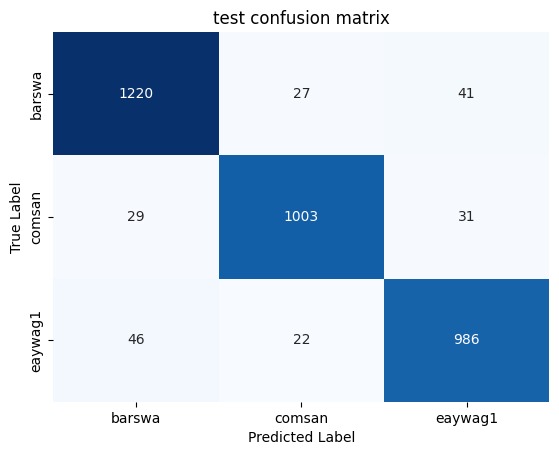

In [ ]:
# calculate the confusion matrix
test_cm = tf.math.confusion_matrix(test_labels, test_yhat_result)

# use a heatmap to display the confusion matrix
ax = sns.heatmap(test_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=le.classes_,
                 yticklabels=le.classes_,
                 cbar=False)

# add axis labels
ax.set(xlabel='Predicted Label',ylabel='True Label')
plt.title('test confusion matrix')
plt.show()

# Visualize intermediate layers

In [ ]:
def get_layer_output(model, layer_name, input_arr):
  input = model.input
  layer_output = model.get_layer(layer_name).output
  layer_m = Model(input, layer_output)
  return tf.squeeze(layer_m(np.array([input_arr]))).numpy()

In [ ]:
def plot_layer_output(model, layer_name, input_arr):
  out = get_layer_output(model, layer_name, input_arr)
  plt.imshow(out.T, aspect='auto', interpolation='none', origin='lower')

In [191]:
test_frames_df.iloc[7]

primary_label                     eaywag1
primary_label_enc                       2
filename_npy         eaywag1/XC132637.npy
duration_secs                   40.359229
frame_length_s                        8.0
hop_length_s                          4.0
total_frames                            9
frame_id                                6
Name: 7, dtype: object

In [192]:
sample_input = test_features[7]
sample_input.shape

(33, 2001)

In [194]:
Audio(test_frames[7], rate=16000)

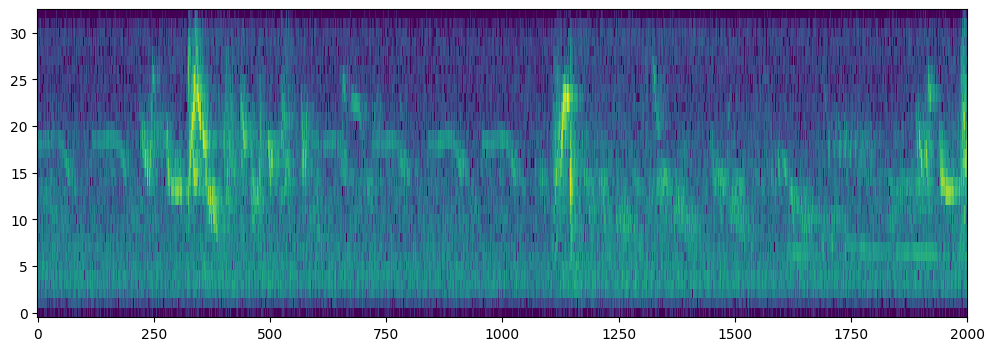

In [193]:
plt.figure(figsize=(12,4))
plt.imshow(sample_input, aspect='auto', interpolation='none', origin='lower')

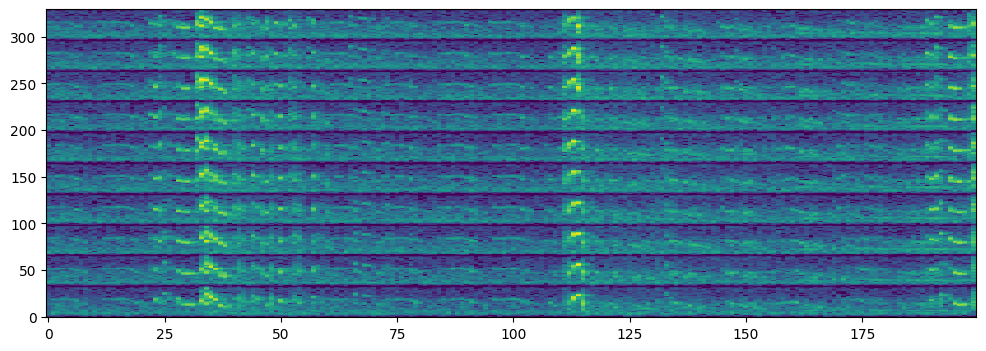

In [195]:
plt.figure(figsize=(12,4))
plot_layer_output(model, 'reshape_1', sample_input)

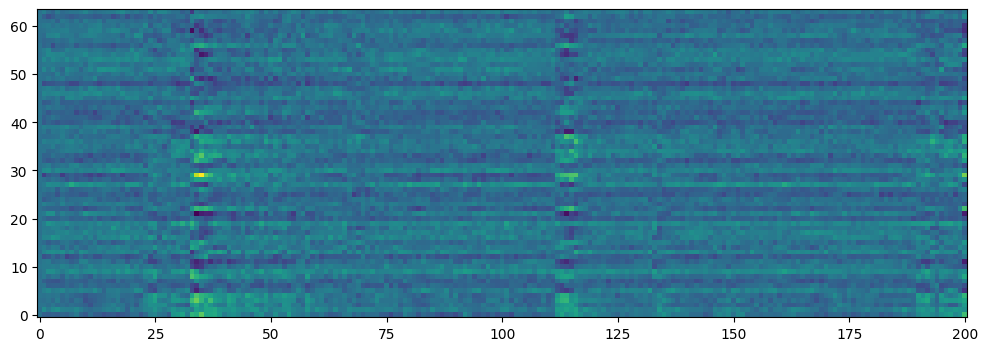

In [196]:
plt.figure(figsize=(12,4))
plot_layer_output(model, 'patch_encoder', sample_input)

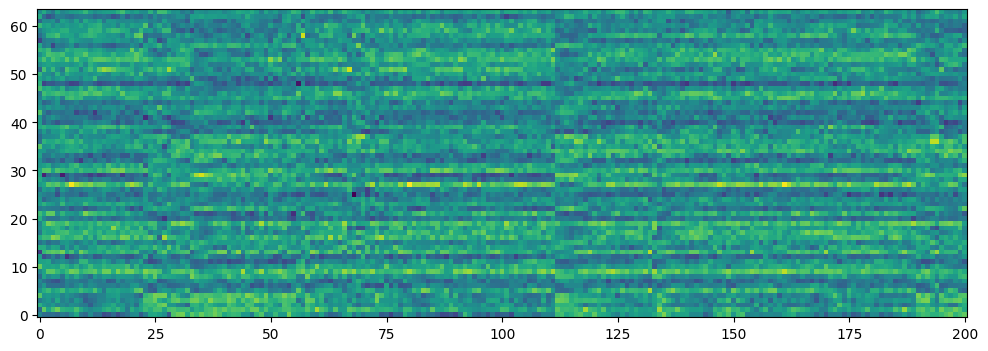

In [197]:
plt.figure(figsize=(12,4))
plot_layer_output(model, 'layer_normalization', sample_input)

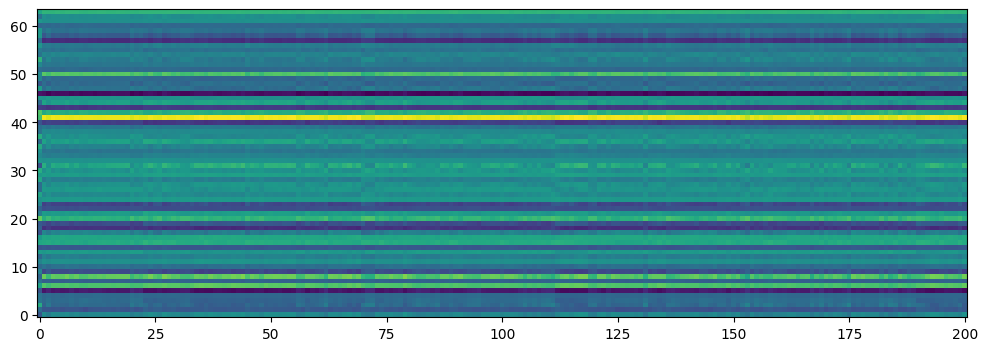

In [198]:
plt.figure(figsize=(12,4))
plot_layer_output(model, 'multi_head_attention', sample_input)

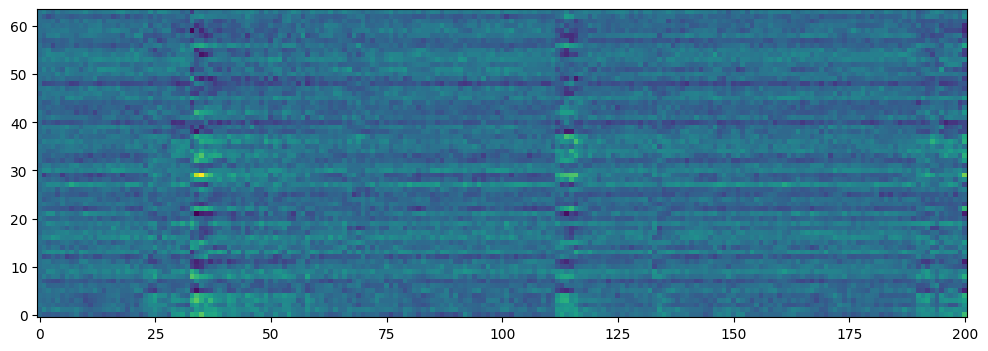

In [199]:
plt.figure(figsize=(12,4))
plot_layer_output(model, 'add', sample_input)

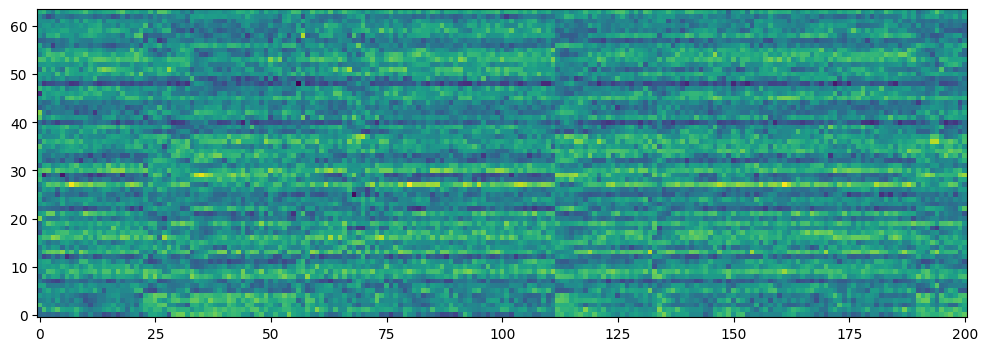

In [200]:
plt.figure(figsize=(12,4))
plot_layer_output(model, 'layer_normalization_1', sample_input)

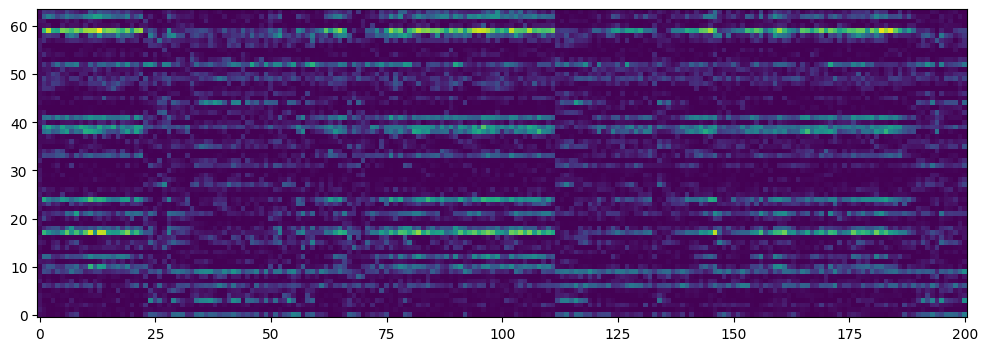

In [201]:
plt.figure(figsize=(12,4))
plot_layer_output(model, 'ffn', sample_input)

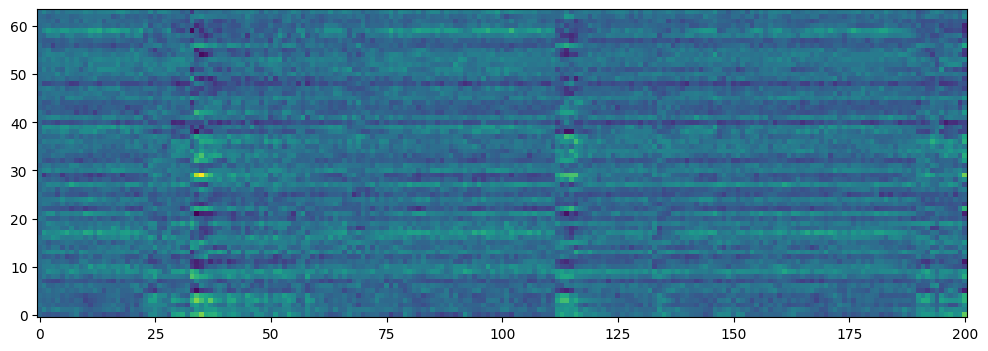

In [202]:
plt.figure(figsize=(12,4))
plot_layer_output(model, 'add_1', sample_input)

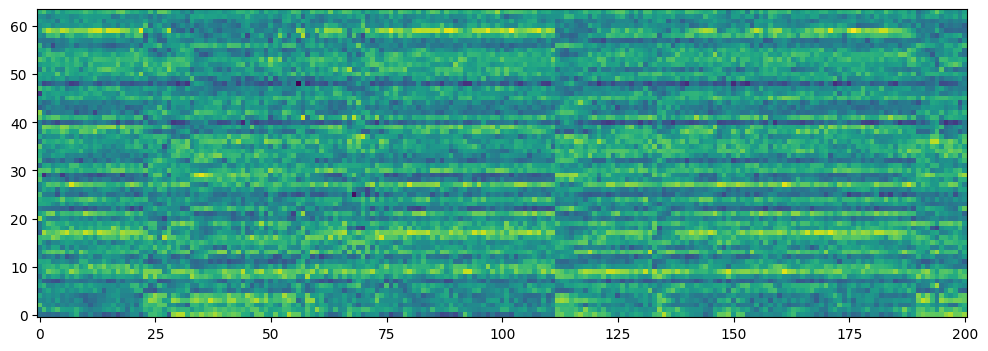

In [203]:
plt.figure(figsize=(12,4))
plot_layer_output(model, 'layer_normalization_2', sample_input)

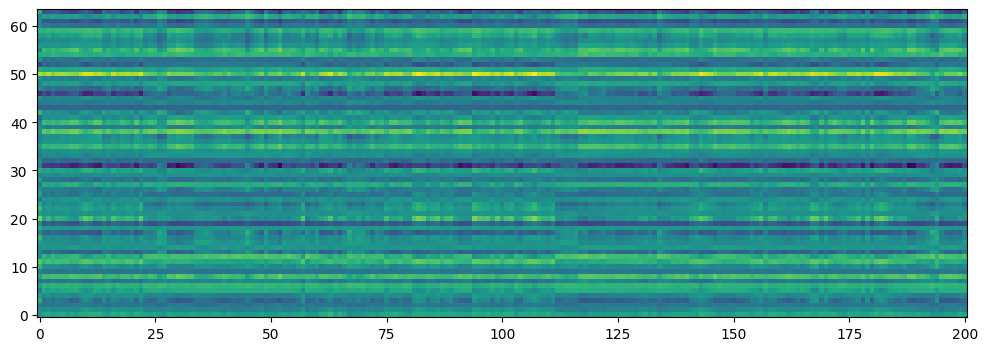

In [204]:
plt.figure(figsize=(12,4))
plot_layer_output(model, 'multi_head_attention_1', sample_input)

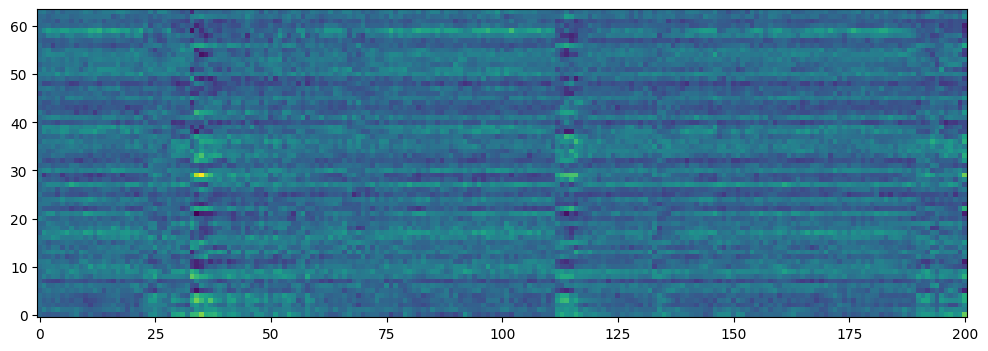

In [205]:
plt.figure(figsize=(12,4))
plot_layer_output(model, 'add_2', sample_input)

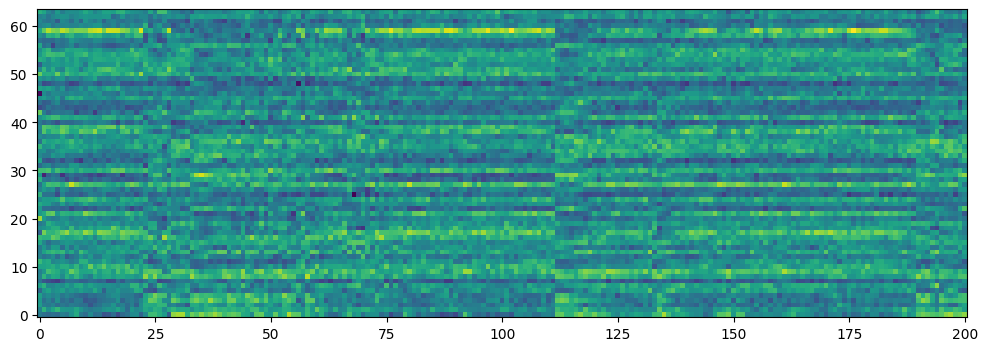

In [206]:
plt.figure(figsize=(12,4))
plot_layer_output(model, 'layer_normalization_3', sample_input)

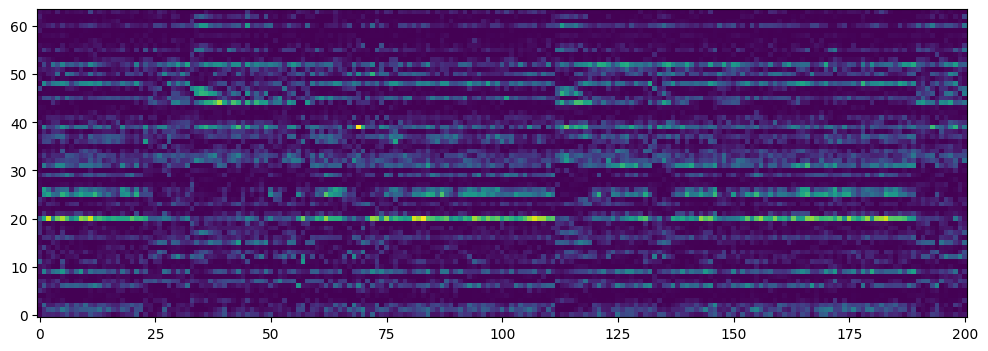

In [207]:
plt.figure(figsize=(12,4))
plot_layer_output(model, 'ffn_1', sample_input)

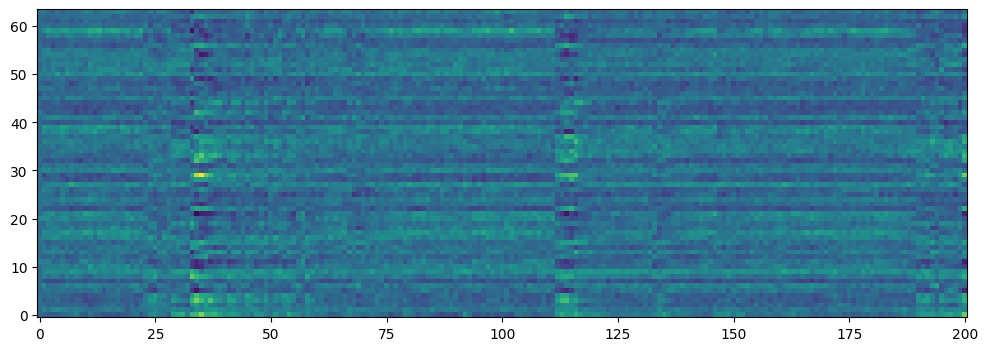

In [208]:
plt.figure(figsize=(12,4))
plot_layer_output(model, 'add_3', sample_input)

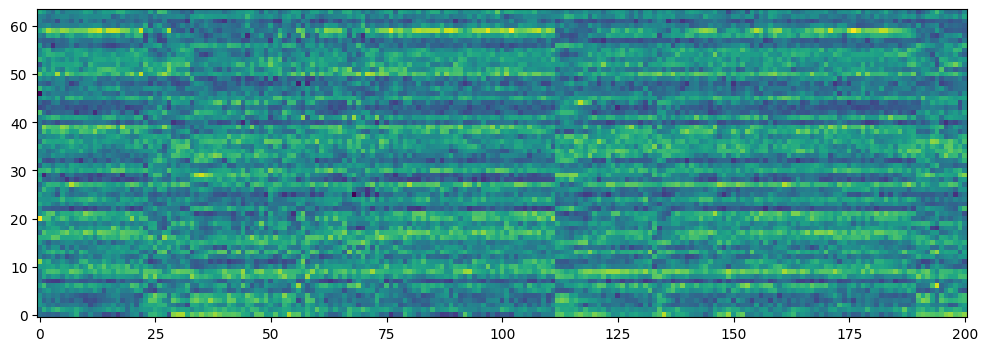

In [209]:
plt.figure(figsize=(12,4))
plot_layer_output(model, 'layer_normalization_4', sample_input)

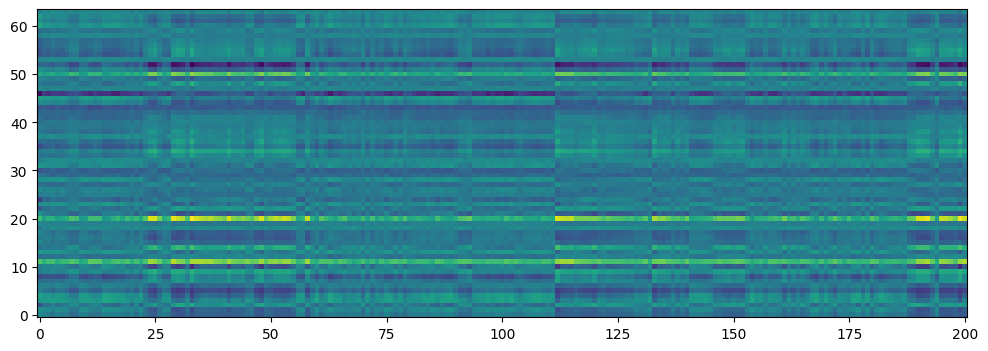

In [210]:
plt.figure(figsize=(12,4))
plot_layer_output(model, 'multi_head_attention_2', sample_input)

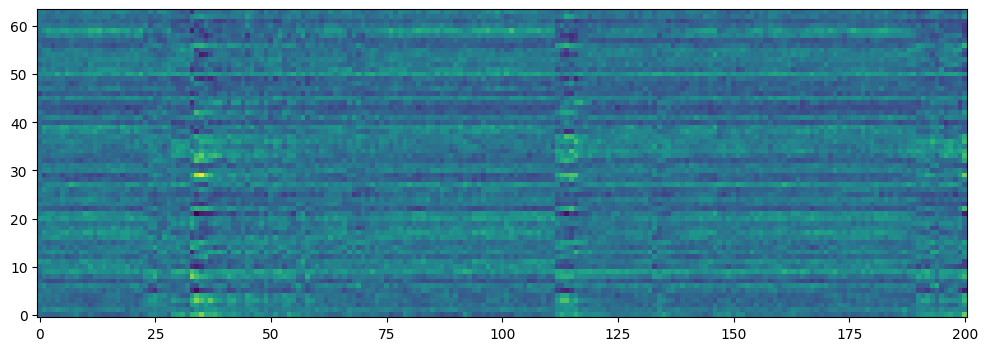

In [211]:
plt.figure(figsize=(12,4))
plot_layer_output(model, 'add_4', sample_input)

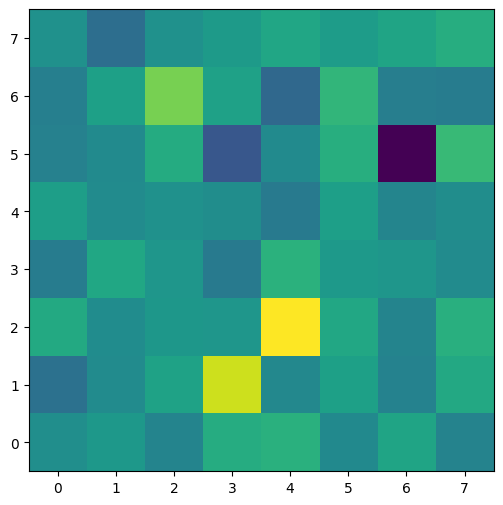

In [212]:
arr = get_layer_output(model, 'cropping1d', sample_input).reshape((8,8))
plt.figure(figsize=(6,6))
plt.imshow(arr, aspect='auto', interpolation='none', origin='lower')

In [213]:
preds = get_layer_output(model, 'dense_5', sample_input)
preds

array([ 1.8665205 , -2.6728654 ,  0.39108634], dtype=float32)

In [214]:
preds_sm = np.exp(preds) / np.sum(np.exp(preds), axis=0)
preds_sm

array([0.80686843, 0.00861732, 0.1845142 ], dtype=float32)